In [2]:
# Data science libraries
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path
import os
import openpyxl

In [3]:
import sys
sys.path
sys.path.append(r"D:\本科项目资料\故障诊断科研")

In [4]:
from helper import get_df_all, download
from train_helper import get_dataloader, fit, validate 
import nn_model
from data_urls import URLS

D:\xws\Python\conda\envs\xwstorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     torch.cuda.manual_seed(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
     torch.backends.cudnn.enabled = False
     torch.backends.cudnn.benchmark = False
    
setup_seed(220)

In [6]:
working_dir = Path(r"D:\本科项目资料\故障诊断科研")
DATA_PATH = Path(working_dir/'Data')
save_model_path = Path(working_dir/'model')
DE_path = DATA_PATH / '12k_DE'

for path in [DATA_PATH, save_model_path]:
    if not path.exists():
        path.mkdir(parents=True)

In [7]:
save_model_path

WindowsPath('D:/本科项目资料/故障诊断科研/model')

In [8]:
bs = 64
lr = 0.001
wd = 1e-5
betas=(0.99, 0.999)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
random_seed = 42


In [9]:
df_all = get_df_all(DE_path, segment_length=500, normalize=True)
features = df_all.columns[2:]
target = 'label'

In [10]:
df_all.sample(5)

,label,filename,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
6254,2,IR021_1.mat,0.200833,-0.631880,-0.521587,0.544580,0.419581,-1.010554,-0.848790,0.830423,...,0.319398,0.779872,0.123628,-0.395669,0.015173,0.391089,-0.041812,-0.239420,0.221973,0.229326
10583,3,OR007@6_3.mat,-0.538173,0.125139,0.439302,-0.525579,-0.163136,0.711484,-0.225409,-1.132915,...,-0.271589,-0.039290,0.149628,0.135634,-0.226809,-0.294679,0.135634,0.383326,-0.062380,-0.258295
3888,2,IR007_0.mat,-0.643549,-1.650346,-0.434938,1.535708,0.856886,-1.976091,-0.523068,2.311025,...,0.407314,0.017424,-0.122580,0.393927,0.300219,-0.553188,-0.581077,0.311933,0.123960,-0.576057
12800,3,OR021@3_0.mat,-0.366848,-0.783143,-0.468472,0.219162,-0.297724,-0.718661,-0.665528,-0.807904,...,0.239280,0.875844,0.872233,1.005323,0.704580,0.737595,0.863463,1.171428,0.362053,-0.190942
6336,2,IR021_2.mat,0.780488,0.046982,-0.595147,-0.286958,0.219767,0.010431,-0.327663,-0.073469,...,0.645915,0.934998,-0.242931,-0.392457,1.101968,1.503195,-0.735535,-1.495623,0.674989,1.408495


In [11]:
df_all.shape

(14592, 502)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df_all[features], 
                                                      df_all[target], 
                                                      test_size=0.50, random_state=random_seed, shuffle=True
                                                     )

In [13]:
## Create DataLoader of train and validation set
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, bs)

In [14]:
## Instantiate model, optimizer and loss function
model = nn_model.CNN_1D_2L(len(features))
model.to(device)
opt = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=wd)
loss_func = CrossEntropyLoss()

In [15]:
%%time
## Train
epochs = 40
model, metrics = fit(epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=True)

EPOCH 	 Train Loss 	 Val Loss 	 Train Acc 	 Val Acc 	 F1_score 	
0 	 0.45399 	 0.47853 	 0.83347 	 0.82675 	 0.80307 	
1 	 0.60006 	 0.66598 	 0.80715 	 0.79756 	 0.77010 	
2 	 0.24810 	 0.31063 	 0.90639 	 0.89200 	 0.88326 	
3 	 0.23691 	 0.29929 	 0.90282 	 0.88665 	 0.87918 	
4 	 0.21946 	 0.28539 	 0.92928 	 0.90913 	 0.90016 	
5 	 0.39544 	 0.47488 	 0.87596 	 0.86732 	 0.85923 	
6 	 0.10249 	 0.15427 	 0.95888 	 0.94257 	 0.93766 	
7 	 0.27264 	 0.35288 	 0.90488 	 0.88884 	 0.88466 	
8 	 0.37494 	 0.47672 	 0.87911 	 0.86390 	 0.85713 	
9 	 0.10914 	 0.17385 	 0.95299 	 0.93764 	 0.93267 	
10 	 0.08903 	 0.15529 	 0.96628 	 0.95312 	 0.95166 	
11 	 0.14521 	 0.22918 	 0.95134 	 0.93366 	 0.93066 	
12 	 0.14388 	 0.22064 	 0.94380 	 0.92914 	 0.92736 	
13 	 0.12788 	 0.20215 	 0.95806 	 0.94161 	 0.93951 	
14 	 0.08874 	 0.15600 	 0.96299 	 0.94545 	 0.94038 	
15 	 0.14241 	 0.22735 	 0.94737 	 0.93311 	 0.93215 	
16 	 0.04113 	 0.09383 	 0.98465 	 0.96820 	 0.96747 	
17 	 0.054

In [16]:
# %%time
# ## Train
# epochs = 20
# model, metrics = fit(epochs, model, loss_func, opt, train_dl, valid_dl, train_metric=False)

In [17]:
# save_path=r'D:\xws\科研'
# #os.makedirs(os.path.dirname(save_path), exist_ok=True)
# torch.save(model.state_dict(), save_path)
# model2 = nn_model.CNN_1D_2L(len(features))
# save_m_path=Path(r'D:\xws')
# model2.load_state_dict(torch.load(save_m_path / '绉戠爺'))
# model2.eval()

In [18]:
#  torch.save(model.state_dict(), "model.pth")
#  model2 = nn_model.CNN_1D_2L(len(features))
#  model2.load_state_dict(torch.load("model.pth"))
#  model2.eval()

In [19]:
%%time
print(validate(model, valid_dl, loss_func))

(0.05423777424648665, 0.9853344298245614, (array([2, 3, 1, ..., 1, 2, 3], dtype=int64), array([2, 3, 1, ..., 1, 2, 3], dtype=int64)), 0.9851636592989474)
CPU times: total: 453 ms
Wall time: 556 ms


In [20]:
filepath=r"D:\本科项目资料\故障诊断科研\baselinedata.xlsx"
metrics.to_excel(filepath, index=False)

In [47]:
data = pd.read_excel(r"D:\本科项目资料\故障诊断科研\baselinedata.xlsx")

# 全部的线段风格
styles = ['c:s','y:8','r:^','r:v','g:D','m:X','b:p',':>',':<',':H','k:o','k:*','y:*','k:*'] # 其他可用风格 ':<',':H','k:o','k:*','k:*','k:*'
# 获取全部的图例


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


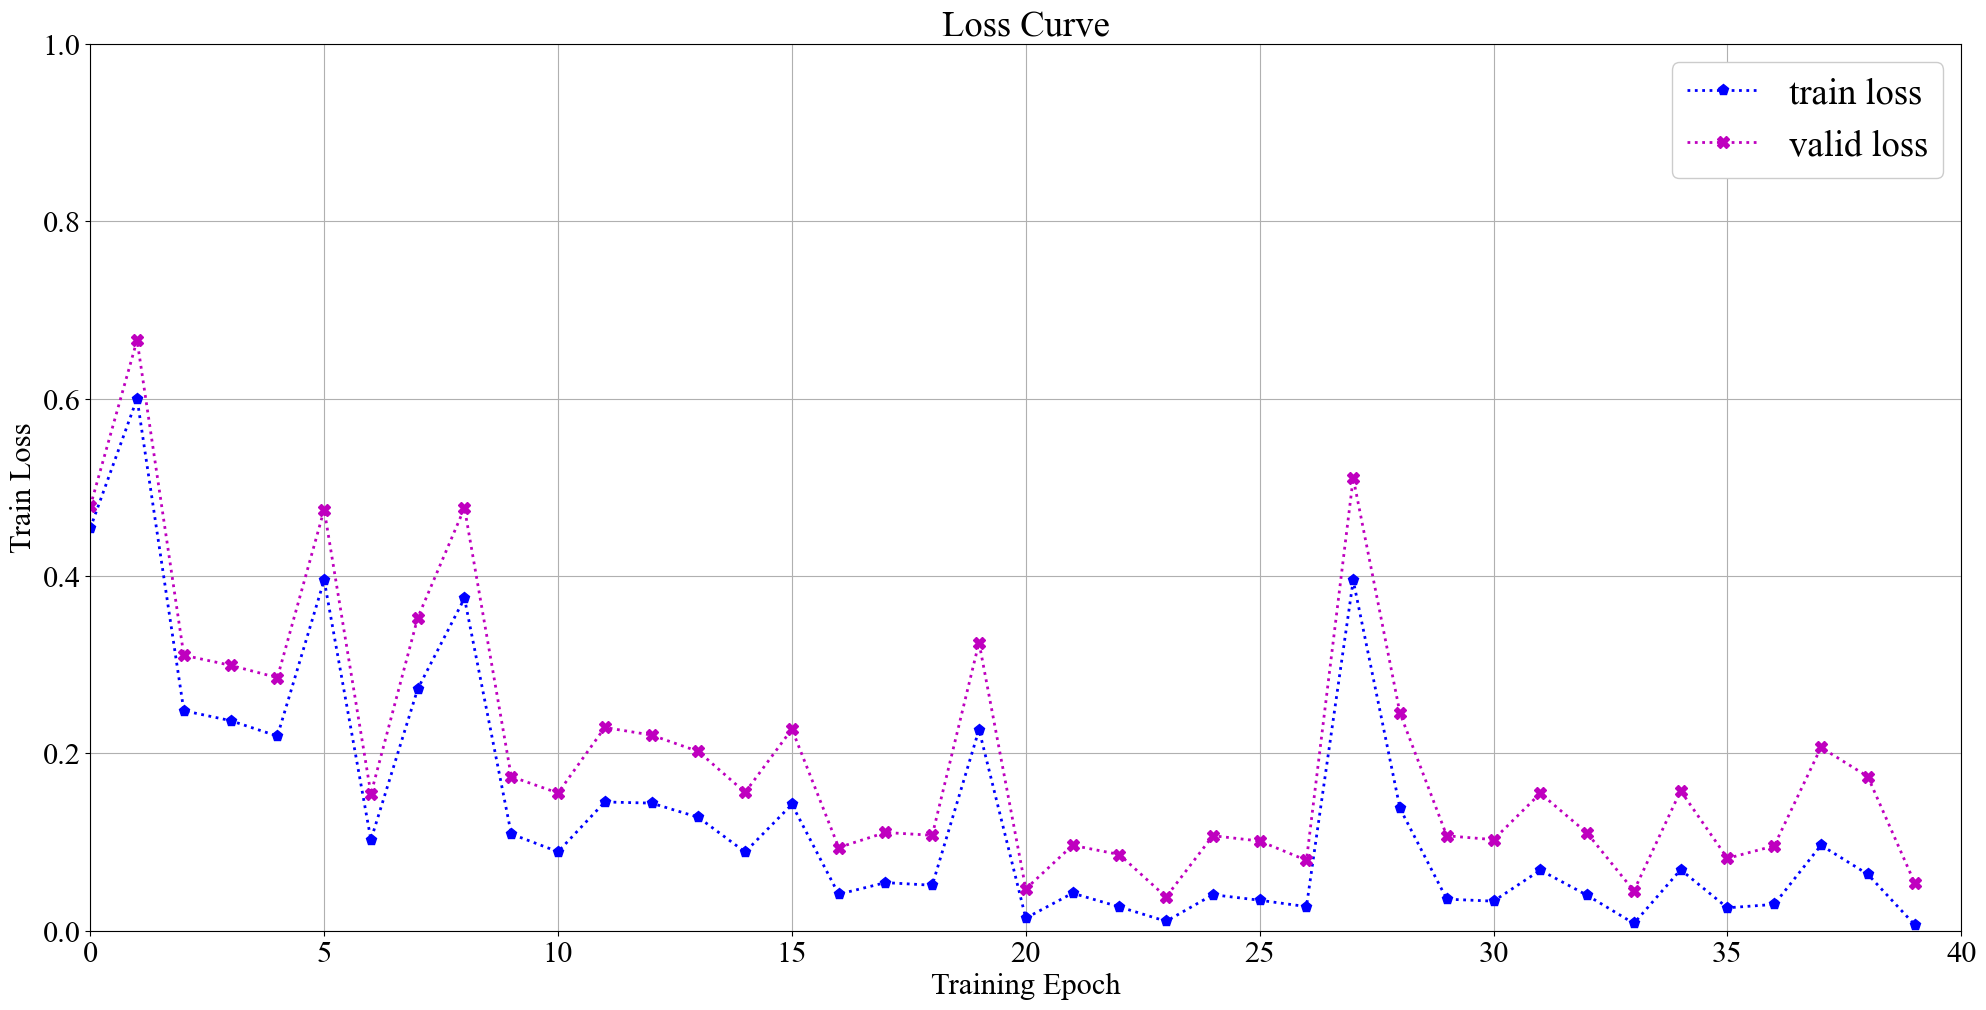

In [49]:
plt.figure(figsize=(20,10))

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=15)
# 设置图片的x,y轴的限制，和对应的标签
plt.xlim([0,40])
plt.ylim([0,1])

plt.grid()
plt.legend(loc='lower right',framealpha=0.7)
plt.tight_layout()

plt.plot(data.values[:,0],styles[6], markersize=8,linewidth=2,label='train loss')
plt.plot(data.values[:,2],styles[5], markersize=8,linewidth=2,label='valid loss')

plt.legend(loc='upper right',framealpha=1,fontsize='large')
plt.xlabel("Training Epoch")
plt.ylabel("Train Loss")
plt.title("Loss Curve")
plt.savefig(r"D:\本科项目资料\故障诊断科研\bslosscurve2.png")
plt.show()





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


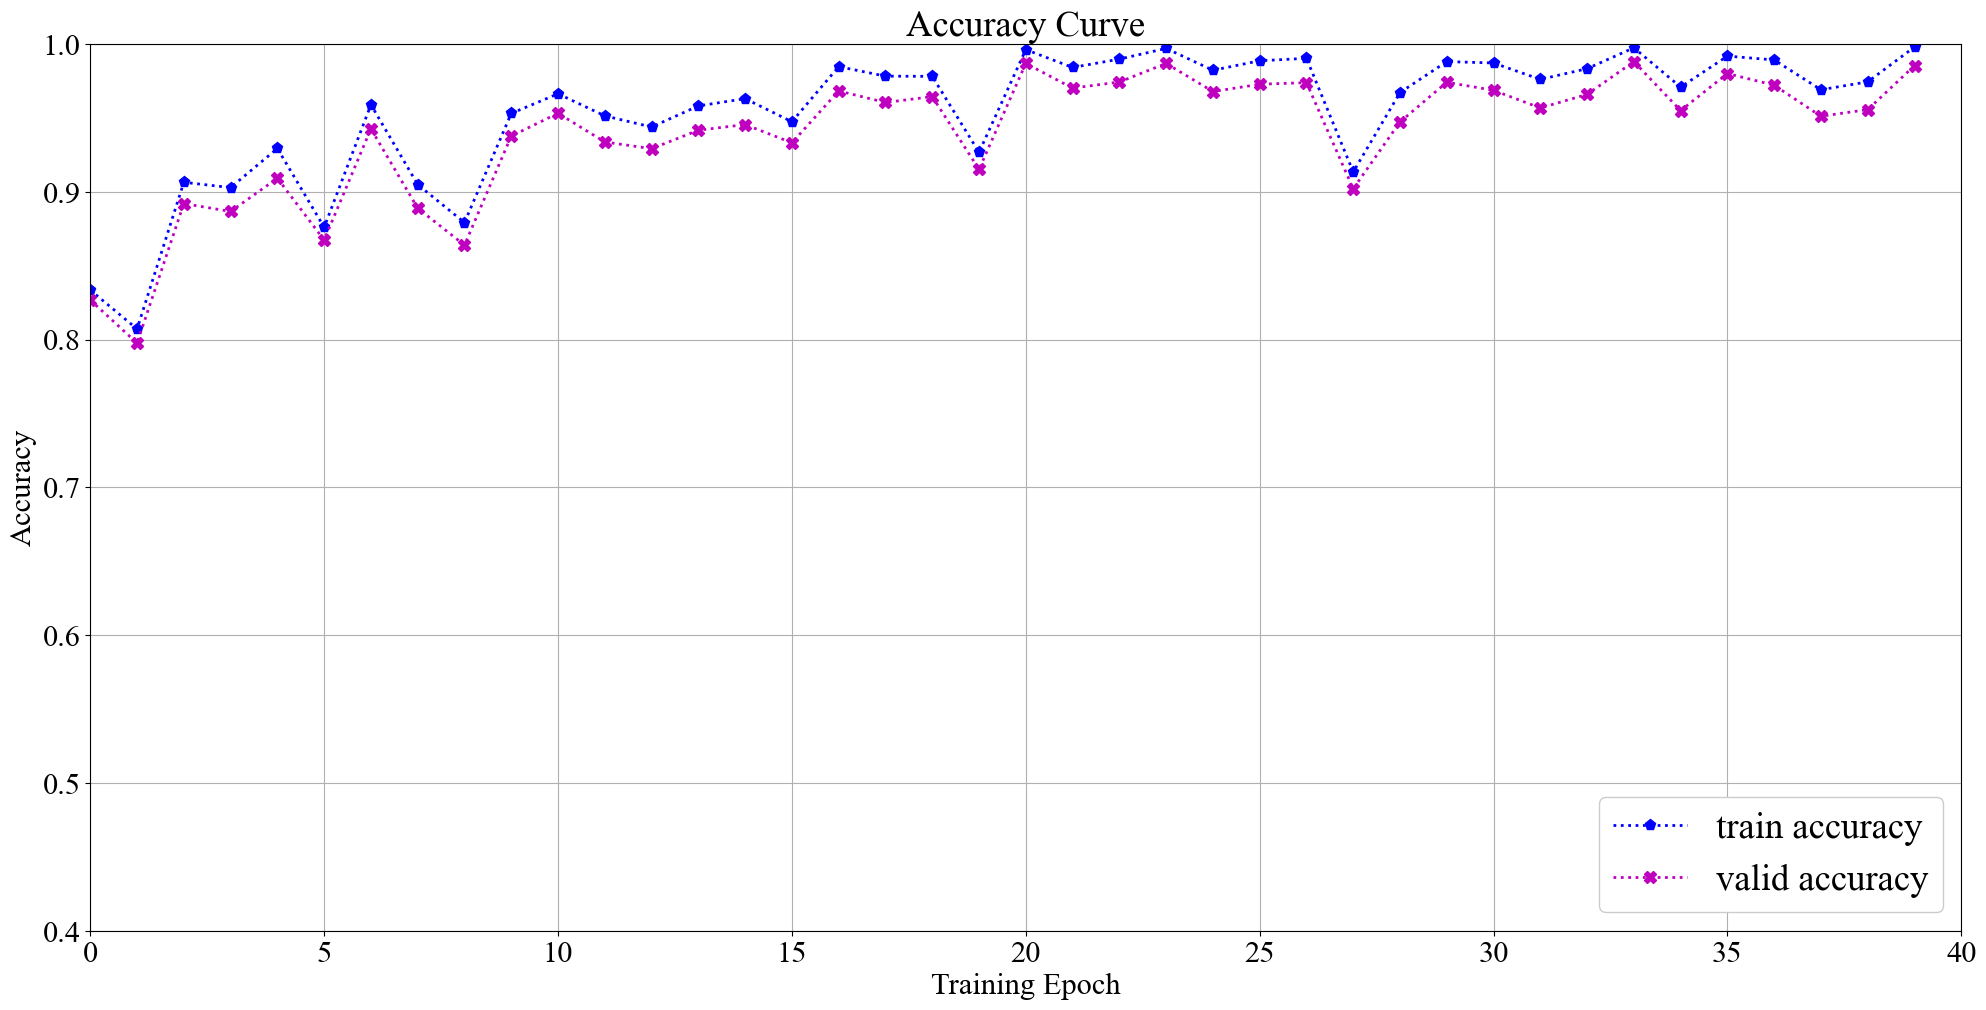

In [51]:
plt.figure(figsize=(20,10))

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=15)
# 设置图片的x,y轴的限制，和对应的标签
plt.xlim([0,40])
plt.ylim([0.4,1])

plt.grid()
plt.legend(loc='lower right',framealpha=0.7)
plt.tight_layout()

plt.plot(data.values[:,1],styles[6], markersize=8,linewidth=2,label='train accuracy')
plt.plot(data.values[:,3],styles[5], markersize=8,linewidth=2,label='valid accuracy')
# plt.plot(data.values[:,4],styles[4], markersize=8,linewidth=2,label='valid f1')
plt.legend(loc='lower right',framealpha=1,fontsize='large')
plt.xlabel("Training Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.savefig(r"D:\本科项目资料\故障诊断科研\bsaccuracycurve2.png")
plt.show()